In [1]:


import tensorflow as tf
from tensorflow import keras
import argparse


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/noisyloss/')




Mounted at /content/drive


In [ ]:
import loss_functions

In [ ]:
crentr_loss_fn = loss_functions.crossentropy_reed_wrap(0.3)

In [ ]:
# Example usage:
alpha = 0.1
beta = 1.0
symloss_fn = loss_functions.symmetric_cross_entropy(alpha, beta)

In [ ]:
lq_loss_fn = loss_functions.lq_loss_wrap(0.3)

In [ ]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image, display

# # Assuming you have created your model using the create_model function
# model = create_model()

# # Generate the plot and get the image data
# # We set to_file=None to prevent saving to a file and get bytes instead
# plot_model(model, show_shapes=True,to_file="./model_arch.jpg")


In [31]:


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [32]:
def create_model():
  # model = keras.Sequential([
  #     keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
  #     keras.layers.MaxPooling2D(pool_size=(2, 2)),
  #     keras.layers.Conv2D(64, (3, 3), activation='relu'),
  #     keras.layers.MaxPooling2D(pool_size=(2, 2)),
  #     keras.layers.Flatten(),
  #     keras.layers.Dropout(0.5),
  #     keras.layers.Dense(10, activation='softmax')
  # ])

  model = keras.Sequential([
    # Input Layer (implicitly defined by the input_shape of the first dense layer)
    # The first Dense layer takes the 784-dimensional input.
    keras.layers.Reshape((784,), input_shape=(28, 28, 1)), # Add this layer to flatten the input
    keras.layers.Dense(128, activation="relu", name="hidden_layer_1"),

    # Hidden Layer 2
    # This layer takes input from the first hidden layer.
    keras.layers.Dense(64, activation="relu", name="hidden_layer_2"),

    # Output Layer
    # 10 neurons for 10 classes (digits 0-9).
    # 'softmax' activation ensures the output is a probability distribution.
    keras.layers.Dense(10, activation="softmax", name="output_layer")
  ])
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


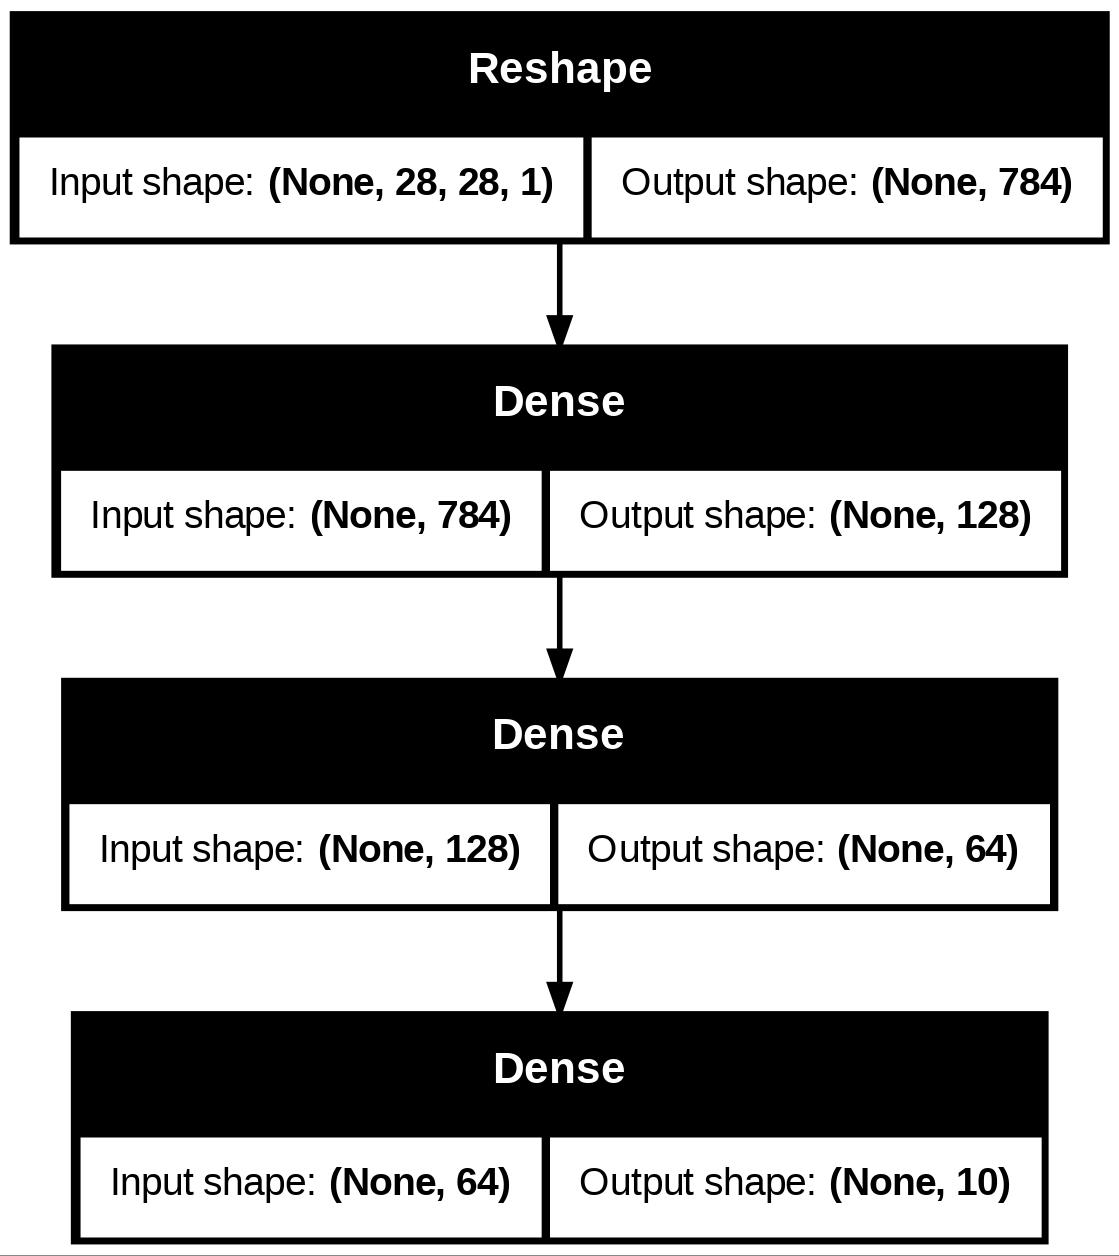

In [ ]:
# prompt: give code to print image of the keras model

from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Assuming you have created your model using the create_model function
model = create_model()

# Generate the plot and get the image data
# We set to_file=None to prevent saving to a file and get bytes instead
plot_model(model, show_shapes=True,to_file="./model_arch.jpg")
display(Image('model_arch.jpg'))

## noisy labels

In [33]:
import numpy as np
NOISE_LEVEL=0.6  # what part of training labels are permuted
perm = np.array([7, 9, 0, 4, 2, 1, 3, 5, 6, 8])  # noise permutation (from Reed)

In [34]:
noise = perm[y_train]

In [35]:
# replace some of the training labels with permuted (noise) labels.
# make sure each categories receive an equal amount of noise


from sklearn.model_selection import StratifiedShuffleSplit
if NOISE_LEVEL > 0:
  _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                  test_size=NOISE_LEVEL,
                                                  random_state=42).split(x_train,y_train)))
  y_train_noise = y_train.copy()
  y_train_noise[noise_idx] = noise[noise_idx]
  # break the training set to 10% validation which we will use for early stopping.
  train_idx, val_idx = next(iter(
          StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                random_state=42).split(x_train, y_train_noise)))
  X_train_train = x_train[train_idx]
  y_train_correct = y_train[train_idx]
  y_train_train = y_train_noise[train_idx]
  X_train_val = x_train[val_idx]
  y_train_val = y_train_noise[val_idx]
  y_train_val_correct = y_train[val_idx]
else:
  train_idx, val_idx = next(iter(
        StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                               random_state=42).split(x_train, y_train)))
  X_train_train = x_train[train_idx]
  y_train_train = y_train[train_idx]
  y_train_correct = y_train[train_idx]
  X_train_val = x_train[val_idx]
  y_train_val = y_train[val_idx]
  y_train_val_correct = y_train[val_idx]





In [36]:
# my_agce_loss = loss_functions.agce_loss_fn(num_classes=10, a=4, q=0.21, scale=1.0)

In [37]:


from keras.callbacks import EarlyStopping
from sklearn import metrics

model = create_model()
model.compile(optimizer='adam',
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])

history = model.fit(X_train_train,
                      y_train_train,
                      batch_size=512,
                      epochs=25,
                      verbose=True,
                      validation_data=(X_train_val,
                                      y_train_val_correct),
                      callbacks=
                      [EarlyStopping(patience=4,mode='min',
                                    verbose=True)]
                      )

# Evaluate the model
#loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
#y_pred = model.predict(x_test)
y_pred_probs = model.predict(x_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels



acc = metrics.accuracy_score(y_test, y_pred)
macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
print("accuracy",acc)
print("macro_f1",macro_averaged_f1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3896 - loss: 1.6324 - val_accuracy: 0.1698 - val_loss: 1.2704
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5252 - loss: 0.9748 - val_accuracy: 0.1433 - val_loss: 1.1669
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5469 - loss: 0.8880 - val_accuracy: 0.1478 - val_loss: 1.1212
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5609 - loss: 0.8464 - val_accuracy: 0.1607 - val_loss: 1.0961
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5714 - loss: 0.8173 - val_accuracy: 0.1592 - val_loss: 1.0890
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5788 - loss: 0.7949 - val_accuracy: 0.1718 - val_loss: 1.0773
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5863 - loss: 0.7768 - val_accuracy: 0.1793 - val_loss: 1.0764
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5931 - loss: 0.7614 - val_accuracy: 

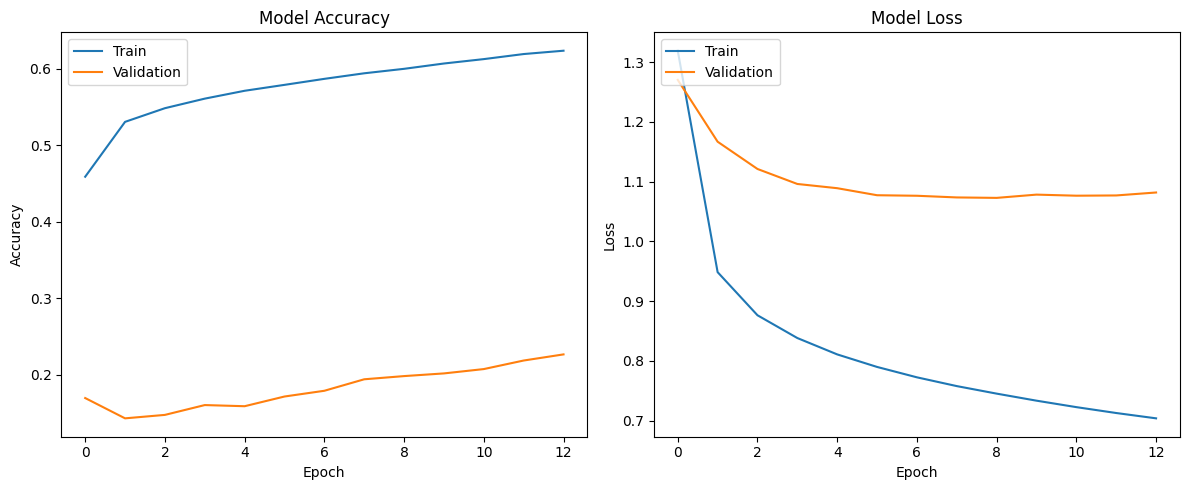

In [38]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
print(NOISE_LEVEL)

0.6


In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

from keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np

seeds = [42, 123, 456]
all_results = []

for seed in seeds:
    print(f"Running with seed: {seed}")
    tf.random.set_seed(seed)
    np.random.seed(seed) # Set numpy seed as well


    if NOISE_LEVEL > 0:
      _, noise_idx = next(iter(StratifiedShuffleSplit(n_splits=1,
                                                      test_size=NOISE_LEVEL,
                                                      random_state=seed).split(x_train,y_train)))
      y_train_noise = y_train.copy()
      y_train_noise[noise_idx] = noise[noise_idx]
      # break the training set to 10% validation which we will use for early stopping.
      train_idx, val_idx = next(iter(
              StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                    random_state=seed).split(x_train, y_train_noise)))
      X_train_train = x_train[train_idx]
      y_train_correct = y_train[train_idx]
      y_train_train = y_train_noise[train_idx]
      X_train_val = x_train[val_idx]
      y_train_val = y_train_noise[val_idx]
      y_train_val_correct = y_train[val_idx]
    else:
      train_idx, val_idx = next(iter(
            StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                                  random_state=seed).split(x_train, y_train)))
      X_train_train = x_train[train_idx]
      y_train_train = y_train[train_idx]
      y_train_correct = y_train[train_idx]
      X_train_val = x_train[val_idx]
      y_train_val = y_train[val_idx]
      y_train_val_correct = y_train[val_idx]

    model = create_model()
    model.compile(optimizer='adam',
                        loss="sparse_categorical_crossentropy",
                        metrics=['accuracy'])

    train_res = model.fit(X_train_train,
                          y_train_train,
                          batch_size=512,
                          epochs=25,
                          verbose=True,
                          validation_data=(X_train_val,
                                          y_train_val_correct),
                          callbacks=
                          [EarlyStopping(patience=4,mode='min',
                                        verbose=True)]
                          )

    # Evaluate the model
    #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    #y_pred = model.predict(x_test)
    y_pred_probs = model.predict(x_test)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

    acc = metrics.accuracy_score(y_test, y_pred)
    macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')
    all_results.append(acc)
    print("accuracy",acc)
    print("macro_f1",macro_averaged_f1)


mean_accuracy = np.mean(all_results)
std_accuracy = np.std(all_results)

print(f"Mean accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}")

Running with seed: 42


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3824 - loss: 1.6741 - val_accuracy: 0.1972 - val_loss: 1.2673
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5206 - loss: 0.9987 - val_accuracy: 0.1840 - val_loss: 1.1605
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5431 - loss: 0.9049 - val_accuracy: 0.1708 - val_loss: 1.1167
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5543 - loss: 0.8587 - val_accuracy: 0.1710 - val_loss: 1.0979
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5614 - loss: 0.8279 - val_accuracy: 0.1815 - val_loss: 1.0762
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5678 - loss: 0.8051 - val_accuracy: 0.1832 - val_loss: 1.0647
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5771 - loss: 0.7867 - val_accuracy: 0.1887 - val_loss: 1.0618
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5826 - loss: 0.7707 - val_accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3874 - loss: 1.6513 - val_accuracy: 0.1615 - val_loss: 1.2867
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5282 - loss: 0.9740 - val_accuracy: 0.1820 - val_loss: 1.1530
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5464 - loss: 0.8819 - val_accuracy: 0.1893 - val_loss: 1.1132
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5556 - loss: 0.8401 - val_accuracy: 0.1978 - val_loss: 1.1003
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5648 - loss: 0.8130 - val_accuracy: 0.2003 - val_loss: 1.0899
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5735 - loss: 0.7915 - val_accuracy: 0.1962 - val_loss: 1.0847
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5819 - loss: 0.7743 - val_accuracy: 0.1988 - val_loss: 1.0785
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5856 - loss: 0.7599 - val_accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3816 - loss: 1.6067 - val_accuracy: 0.1773 - val_loss: 1.3045
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5218 - loss: 0.9871 - val_accuracy: 0.1622 - val_loss: 1.1964
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5422 - loss: 0.8919 - val_accuracy: 0.1445 - val_loss: 1.1559
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5568 - loss: 0.8464 - val_accuracy: 0.1473 - val_loss: 1.1320
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5630 - loss: 0.8163 - val_accuracy: 0.1425 - val_loss: 1.1239
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5715 - loss: 0.7939 - val_accuracy: 0.1475 - val_loss: 1.1168
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5798 - loss: 0.7756 - val_accuracy: 0.1458 - val_loss: 1.1202
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5872 - loss: 0.7604 - val_accuracy: 

In [ ]:


# from keras.callbacks import EarlyStopping
# from sklearn import metrics

# func_dict = {
#     "sparse_categorical_crossentropy":"sparse_categorical_crossentropy",
#     "crossentropy_max_wrap": c_mwrap_lossfn,
#     "lq_loss_wrap": lq_loss_fn,
#     "symmetric_cross_entropy": symloss_fn,
#     "crossentropy_reed_wrap": crentr_loss_fn,
#     "noise_aware_loss":noise_aware_loss

# }

# data_dict = []
# for loss_func_name in func_dict.keys():
#     lossfunction = func_dict[loss_func_name]
#     model = create_model()
#     model.compile(optimizer='adam',
#                     loss=lossfunction,
#                     metrics=['accuracy'])

#     # Train the model
#     #model.fit(x_train, y_train, epochs=5)

#     train_res = model.fit(X_train_train,
#                           y_train_train,
#                           batch_size=512,
#                           epochs=5,
#                           verbose=True,
#                           validation_data=(X_train_val,
#                                           y_train_val),
#                           callbacks=
#                           [EarlyStopping(patience=4,mode='min',
#                                         verbose=True)]
#                           )

#     # Evaluate the model
#     #loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
#     #y_pred = model.predict(x_test)
#     y_pred_probs = model.predict(x_test)  # Get predicted probabilities
#     y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels



#     acc = metrics.accuracy_score(y_test, y_pred)
#     macro_averaged_f1 = metrics.f1_score(y_test, y_pred, average = 'macro')

#     rec = {'lossfunc': loss_func_name, 'acc': acc, 'macro_f1':macro_averaged_f1 }
#     data_dict.append(rec.copy())




In [ ]:
# import pandas as pd
# res_df = pd.DataFrame(data_dict)
# res_df